In [2]:
import pandas as pd
import streamlit as st
import sqlite3
import matplotlib.pyplot as plt
import altair as alt
import sys
sys.path.insert(0, '.')
from utils import *

### Conexão com o banco de dados

In [3]:
class DbConn:

    def __init__(self) -> None:
        self.conn = sqlite3.connect("../data/latest.db") 

    def execute_sql(self, query:str, params:dict = None, return_df:bool = True): 

        cur = self.conn.cursor() 
        try:
            if params is not None:
                cur.execute(query, params) 
            else:
                cur.execute(query) 
            if return_df:
                column_names = [col[0] for col in cur.description] 
                query_data = cur.fetchall() 
                query_df = pd.DataFrame.from_records(query_data, columns=column_names) 
                res = query_df 

            return res 
        finally:
            cur.close() 

    def commit(self):
        self.conn.commit() 
        self.conn.close() 

def getLvl1Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 1;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  

    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    return df

def getLvl2Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 2;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  
    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    st.session_state['downloaded_lvl2_data'] = True

    return df


### Funções Auxiliares

In [4]:
def epidemiological_features():
    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']
    return epidemiological_features 
    
def get_feature_time_series_lvl_1(df:pd.DataFrame, feature:str, administrative_area_level_1:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 1 and administrative_area_level_1 == @administrative_area_level_1')

    df = df[['date', feature]] 

    df['date'] = pd.to_datetime(df['date'])

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

def get_feature_time_series_lvl_2(df:pd.DataFrame, feature:str, administrative_area_level_2:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 2 and administrative_area_level_2 == @administrative_area_level_2')

    df = df[['date', feature]] 

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df  

def get_feature_time_series_lvl_3(df:pd.DataFrame, feature:str, administrative_area_level_3:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 3 and administrative_area_level_3 == @administrative_area_level_3')

    df = df[['date', feature]] 

    df = df.set_index('date')


    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

In [5]:
df = getLvl1Data()

In [6]:
print(df.columns)

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population'],
      dtype='object')


In [55]:
br_confirmed = get_feature_time_series_lvl_1(df, feature='confirmed', administrative_area_level_1='Brazil')
br_confirmed.reset_index(inplace=True)

In [9]:
plt.rc('axes', titlesize='medium')
plt.rc('axes', titlelocation='left')
plt.rc('axes.spines', right=False)
plt.rc('axes.spines', top=False)
sizets = (8,6)
plt.rc('figure', figsize=sizets)

In [10]:
def plot_time_series(df:pd.DataFrame):
    
    feature = df.columns[0].title()

    ax = df.iloc[:,0].plot(figsize=sizets)
    plt.suptitle('Cumulative Confirmed')
    ax.set(ylabel=f'{feature}', title='Test')
    ax.grid() 

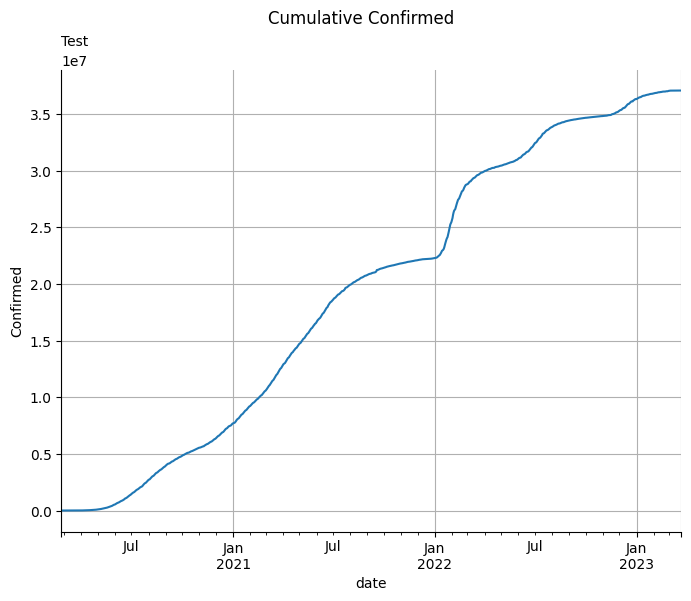

In [11]:
plot_time_series(br_confirmed)

### Plotting the Data with Altair

In [12]:
test_df = br_confirmed.reset_index()
test_df.melt(id_vars='date')

,date,variable,value
0,2020-02-25,confirmed,1.0
1,2020-02-26,confirmed,1.0
2,2020-02-27,confirmed,1.0
3,2020-02-28,confirmed,2.0
4,2020-02-29,confirmed,2.0
...,...,...,...
1118,2023-03-19,confirmed,37085520.0
1119,2023-03-20,confirmed,37085520.0
1120,2023-03-21,confirmed,37085520.0
1121,2023-03-22,confirmed,37085520.0


In [13]:
alt.Chart(data=br_confirmed.reset_index().melt(id_vars='date')).mark_line().encode(
    x = 'date:T', 
    y = 'value:Q'
).properties(
    width=800, 
    height=400
)

alt.Chart(...)

### Resample Time-Series

In [135]:
def resample_time_series(data_frame, time_column, value_column, time_window):
    """
    Resample a time series DataFrame based on the desired time window.

    Parameters:
    - data_frame (pd.DataFrame): DataFrame containing the time series data.
    - time_column (str): Name of the column containing time information.
    - value_column (str): Name of the column containing the values.
    - time_window (str): Pandas offset alias for the desired time window
                        ('D' for daily, 'W' for weekly, 'M' for monthly, etc.).

    Returns:
    - pd.DataFrame: Resampled time series DataFrame.
    """

    df = data_frame.copy()

    # Ensure the time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])

    # Set the time column as the DataFrame index
    df.set_index(time_column, inplace=True)

    # Resample the time series based on the specified time window
    resampled_df = df[value_column].resample(time_window).sum()

    # Convert the index to a column named 'date' and reset the index
    resampled_df = pd.DataFrame(resampled_df)
    resampled_df.reset_index(inplace=True)
    # resampled_df['date'] = pd.to_numeric(pd.to_datetime(resampled_df[time_column]))

    return resampled_df

In [139]:
monthly_df = resample_time_series(br_confirmed, time_column='date', value_column='confirmed', time_window='M')
weekly_df = resample_time_series(br_confirmed, time_column='date', value_column='confirmed', time_window='W')
yearly_df = resample_time_series(br_confirmed, time_column='date', value_column='confirmed', time_window='Y')

## Decomposição de Série Temporal

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose


multiplicative_decomposition = seasonal_decompose(monthly_df['confirmed'], model='multiplicative', period=12) 

## Tendência 


<Axes: >

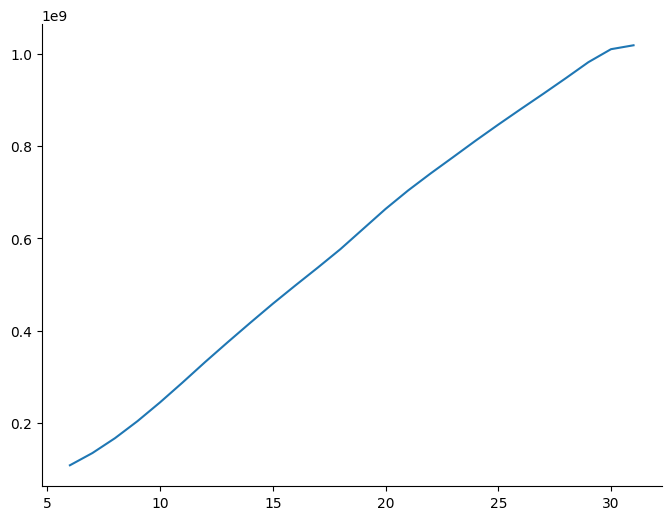

In [103]:
multiplicative_decomposition.trend.plot()

## Sazonalidade

<Axes: >

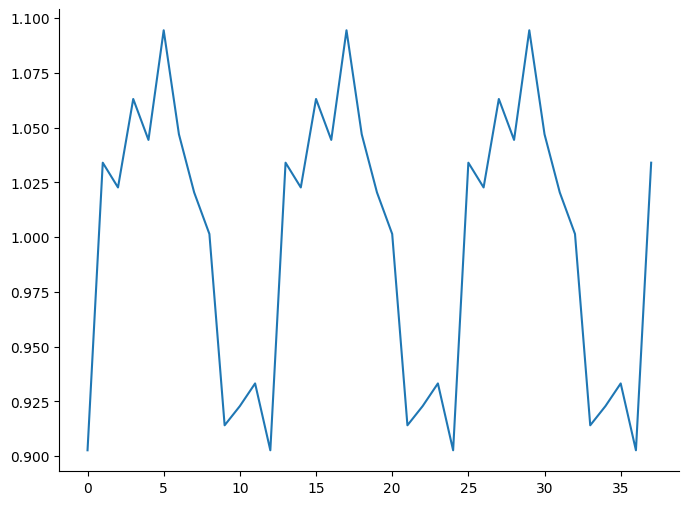

In [104]:
multiplicative_decomposition.seasonal.plot()

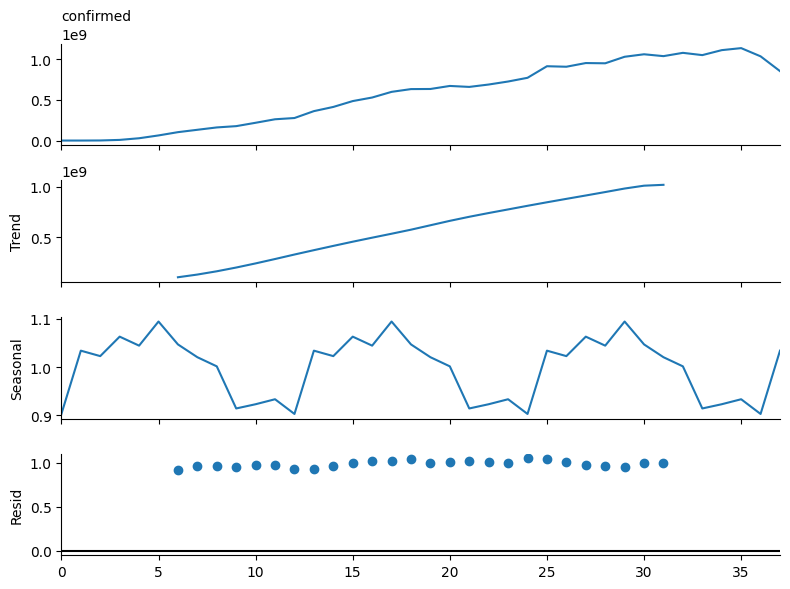

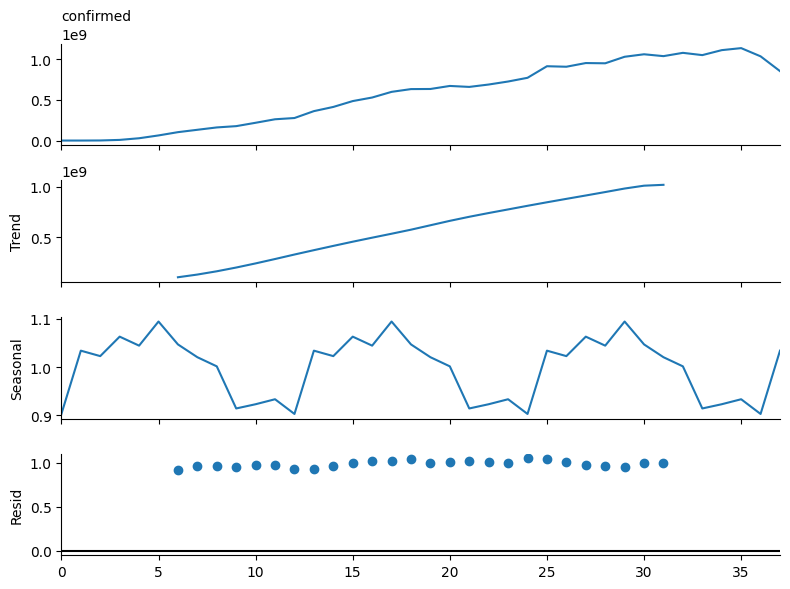

In [105]:
multiplicative_decomposition.plot()

## Diferenciando a Série Temporal

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

def difference_time_series(time_series, lags=1):
    """
    Perform differencing on a time series.

    Parameters:
    - time_series (pd.Series): Time series to be differenced.
    - lags (int): Number of lags for differencing (default is 1).

    Returns:
    - pd.Series: Differenced time series.
    """
    return time_series.diff(lags).dropna()

def test_stationarity(time_series):
    """
    Test the stationarity of a time series using the Augmented Dickey-Fuller test.

    Parameters:
    - time_series (pd.Series): Time series to be tested for stationarity.

    Returns:
    - None
    """
    result = adfuller(time_series)
    p_value = result[1]

    # Print ADF test results
    print(f'Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if p_value <= 0.05:
        print('\nThe time series is likely stationary based on the ADF test.')
    else:
        print('\nThe time series is likely non-stationary based on the ADF test.')

def plot_decomposition(time_series, lags=1, model:str = ['additive', 'multiplicative']):
    """
    Plot the decomposed series of a differenced time series.

    Parameters:
    - time_series (pd.Series): Differenced time series to be decomposed.
    - lags (int): Number of lags for differencing (default is 1).
    - model (str): Decomposition method: 'additive' or 'multiplicative'.

    Returns:
    - None
    """
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(time_series, model='multiplicative')

    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    plt.plot(time_series, label='Original Series')
    plt.title('Original Time Series')

    plt.subplot(4, 1, 2)
    plt.plot(difference_time_series(time_series, lags=lags), label=f'Differenced Series (lags={lags})')
    plt.title('Differenced Time Series')

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.trend, label='Trend')
    plt.title('Trend Component')

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residuals')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()

In [128]:
#set date as index
weekly_df.set_index('date', inplace=True)

#serie differenciated by one lag 
lagged1_ts = difference_time_series(weekly_df['confirmed'], lags=1)

#test staionarity 
test_stationarity(lagged1_ts)

Augmented Dickey-Fuller Test Results:
ADF Statistic: 0.9916406979298961
p-value: 0.994176960476594
Critical Values:
   1%: -3.472161410886292
   5%: -2.8798954259680936
   10%: -2.5765565828092245

The time series is likely non-stationary based on the ADF test.


In [140]:
plot_decomposition(weekly_df, lags=1)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

### Gráfico de Autocorrelação da Série Temporal

In [130]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_autocorrelation(time_series, lags=None):
    """
    Plot the autocorrelation of a time series.

    Parameters:
    - time_series (pd.Series): Time series for autocorrelation plotting.
    - lags (int): Number of lags to include in the plot (default is None).

    Returns:
    - None
    """
    plot_acf(time_series, lags=lags)
    plt.title('Autocorrelation Plot')
    plt.show()

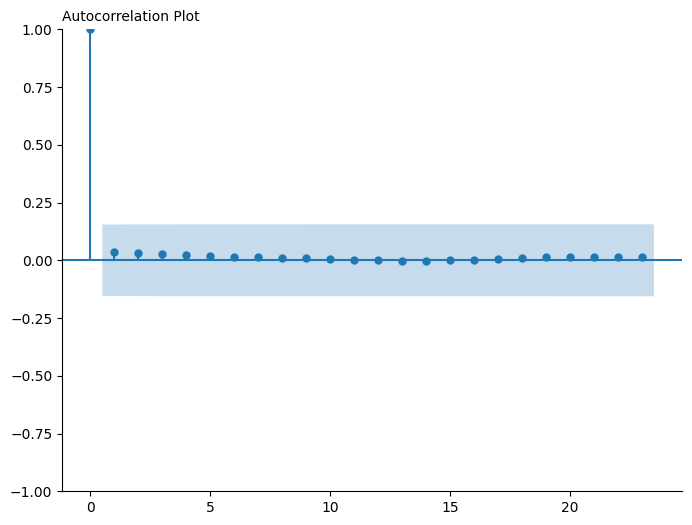

In [134]:
plot_autocorrelation(lagged1_ts)